# Storage of Network Data and Topology

As discussed in the first tutorial, OpenPNM uses Numpy ``ndarrays`` to store all data, and these arrays are all stored in ``dict``s, because all OpenPNM objects are subclassed python dictionaries. In this tutorial will take a deeper dive into the details of the OpenPNM data storage scheme. The sections to be covered are:

- The Spreadsheet Analogy 
- Maintaining Data Integrity
- Representing Topology

## Spreadsheet Analogy

The best analogy for explaining data storage in OpenPNM is the humble spreadsheet.  According to this analogy you can imagine all data is stored in a table; two tables actually, one for pore data and one for throat data.  Each pore (or throat) corresponds to a row and each property corresponds to a column.  Consider the following network with 4 pores, 3 throats:

In [1]:
import openpnm as op
import numpy as np
op.visualization.set_mpl_style()
np.random.seed(0)
pn = op.network.Demo(shape=[4, 1, 1])

Let's use [pandas](https://pandas.pydata.org/) to express the geometric properties as a 'spreadsheet' and pull out all pore properties that are as wide as a single column.

In [2]:
import pandas as pd
pore_data_sheet = pd.DataFrame({k: pn[k] for k in pn.props(element='pore') if pn[k].ndim == 1})

We can now view this 'spreadsheet':

In [3]:
pore_data_sheet

,pore.coordination_number,pore.diameter,pore.max_size,pore.seed,pore.volume
0,1.0,0.474407,1.0,0.474407,0.055905
1,2.0,0.557595,1.0,0.557595,0.090773
2,2.0,0.501382,1.0,0.501382,0.065994
3,1.0,0.472442,1.0,0.472442,0.055213


The column names are the properties such as **pore.volume**, and the rows correspond to the pore index, so pore ``0`` has a volume of 0.055905.  

One could also extract an entire column using:

In [4]:
column = pore_data_sheet['pore.volume']
print(column)

0    0.055905
1    0.090773
2    0.065994
3    0.055213
Name: pore.volume, dtype: float64


Or access individual elements:

In [5]:
print(pore_data_sheet['pore.volume'][0])

0.05590507143096387


```{warning}
The spreadsheet analogy is very apt, but it breaks down slightly when one considers data that is multiple columns wide such as **'pore.coords'**.  The is stored as an Np-by-3 array in the network dictionary, but spreadsheets usually require that all data is only a single column wide. 
```

### Rules to Maintain Data Integrity

Several rules have been implemented to control the integrity of the data. This is implemented by subclassing the `__setitem__` method of the `dict`. Each time data is assigned to a dictionary key, OpenPNM first checks the data type and dictionary key to ensure the rules are followed.  Each of these checks are explored below.

#### All Values are Converted to Numpy Arrays
Only Numpy arrays can be stored in an OpenPNM object, and any data that is written to an OpenPNM object (i.e. dictionary) will be converted to a Numpy array.  This is done to ensure that all mathematical operations throughout the code can be consistently done using vectorization. 

In [6]:
pn['throat.list'] = [1, 2, 3]
print(type(pn['throat.list']))

<class 'numpy.ndarray'>


This illustrates that the basic python list-type has been converted to a Numpy array when stored in the dictionary

#### Dictionary Keys Must Start With 'pore' or 'throat'
All array names must begin with either *'pore.'* or *'throat.'* which serves to identify the type of information they contain.

In [7]:
try:
    pn['foo.bar'] = 0
except:  # noqa E722
    print('This will throw an exception since the dict name cannot start with foo')

This will throw an exception since the dict name cannot start with foo


The pore or throat prefix is enforced so that OpenPNM knows how long an array should be. Attempting to write an array of the wrong length will result in an error:

In [8]:
try:
    pn['pore.test'] = [0, 0, 0]
except:  # noqa E722
    print('This will throw an exception since there are 4 pores, hence all pore arrays should be 4 elements long')

This will throw an exception since there are 4 pores, hence all pore arrays should be 4 elements long


#### Any Scalars are Expanded to a Full-Length Vector
For the sake of consistency only arrays of length *Np* or *Nt* are allowed in the dictionary. Assigning a scalar value to a dictionary results in the creation of a full length vector, either *Np* or *Nt* long, depending on the name of the array. This effectively applies the scalar value to all locations in the network.

In [9]:
pn['pore.test'] = 0
print(pn['pore.test'])

[0 0 0 0]


Note how the scalar value has been cast to an array of 4 elements long, one for each pore in the network. 

#### Nested Dictionary Names are Allowed
It's possible to create nested properties by assigning a dictionary containing numpy arrays

In [10]:
pn['pore.concentration'] = {'species_A': 0, 'species_B': 1}
print(pn['pore.concentration'])

{'species_A': array([0, 0, 0, 0]), 'species_B': array([1, 1, 1, 1])}


The above rule about expanding the scalar values to a numpy array have been applied.  

Requesting the top level of dictionary key returns both concentrations, but they can be accessed directly too:

In [11]:
print(pn['pore.concentration.species_A'])

[0 0 0 0]


You can also retrieve a dictionary by requesting only the element ('pore' or 'throat') and the propname ('concentration'):

In [12]:
pn['pore.concentration']

{'species_A': array([0, 0, 0, 0]), 'species_B': array([1, 1, 1, 1])}

The above returns a 'subdictionary' which can be indexed into:

In [13]:
pn['pore.concentration']['species_A']

array([0, 0, 0, 0])

#### Boolean Arrays are Treated as Labels, Numerical Arrays are Treated as Properties
Any Boolean data will be treated as a *label* while all other numerical data is treated as a *property*. OpenPNM uses *labels* extensively as will be illustrated in a later tutorial. For this tutorial, we'll just introduce the idea.  We can create a new label by assigning `False` to a new key. This will expand the single `False` value into every pore, which means that NO pores have that label (yet):

In [14]:
pn['pore.label'] = False
print(pn.labels(element='pore'))

['pore.label', 'pore.left', 'pore.right', 'pore.surface', 'pore.xmax', 'pore.xmin']


You can see that ``'pore.label'`` shows up in this list automatically since it is of Boolean type. However, if you ask the network which pores have that label, the answer is none:

In [15]:
pn.pores('label')

array([], dtype=int64)

If we then set some locations to `True`, this will change:

In [16]:
pn['pore.label'][[0, 1, 2]] = True
print(pn.pores('label'))

[0 1 2]


OpenPNM objects include a method for creating a label and applying it to locations all in one step using the `set_label` method.

In [17]:
pn.set_label('another', pores=[2, 3])
print(pn.pores('another'))

[2 3]


#### Dictionary Keys with a Leading Underscore are Hidden
Following the Python convention, if a piece of data is not really meant to be seen or used by the user, it can be pre-pended with an underscore and it will not appear in any output.

In [18]:
pn['pore._hidden'] = 1
print(pn.props())

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     : pore.concentration.species_A
2     : pore.concentration.species_B
3     : pore.coordination_number
4     : pore.coords
5     : pore.diameter
6     : pore.max_size
7     : pore.seed
8     : pore.test
9     : pore.volume
10    : throat.conns
11    : throat.cross_sectional_area
12    : throat.diameter
13    : throat.diffusive_size_factors
14    : throat.hydraulic_size_factors
15    : throat.length
16    : throat.lens_volume
17    : throat.list
18    : throat.max_size
19    : throat.spacing
20    : throat.total_volume
21    : throat.volume
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


The ``'pore._hidden'`` key does not show up in this list, though it is present:

In [19]:
pn['pore._hidden']

array([1, 1, 1, 1])

In [20]:
print('pore._hidden' in pn.keys())

True


## The `param` prefix

Expanding all scalar values to arrays that are either Np or Nt long is done as a convenience or shorthand to mean "place this value of X in all pores". It means that you can later ask "what is the value of X in pore Y" and get an answer. This implies that X might take on different values in each pore/throat. However, there are properties which we know are constant, such as the molecular weight or critical temperature of a pure species. In V3 we have introduced the `params` attribute to all object, such that `pn.params` is a dictionary containing such scalar values. For convenience we have also added the ability to read and write to the `params` dictionary via the main get/set method. This is illustrated below:

In [21]:
pn.params['lattice_connectivity'] = 6
print(pn.params)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Parameters                          Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
dimensionality                      (3,)
lattice_connectivity                6
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


```{tip} 
  **Use the "param" prefix:** It is possible use the `param` prefix when reading and writing to the object's dictionary. This intercepts the given key and dispatches the request to the `params` attribute. This feature is particularly useful when passing arguments to pore-scale models (to be discussed in a later tutorial) since you can pass either `arg='param.value'` or `arg='pore.value'` and OpenPNM will be able to fetch the requested data by doing `value = pn[arg]` and both options will work.
```

In [22]:
pn['param.test'] = 2
print(pn.params)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Parameters                          Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
dimensionality                      (3,)
lattice_connectivity                6
test                                2
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


## Representing Topology

Topology was introduced in the last tutorial, but not discussed in depth. Actually, the *next* tutorial will explain topology in full detail, but here we can reveal a little more about it as it pertains to data storage.

Consider the following simple random network:

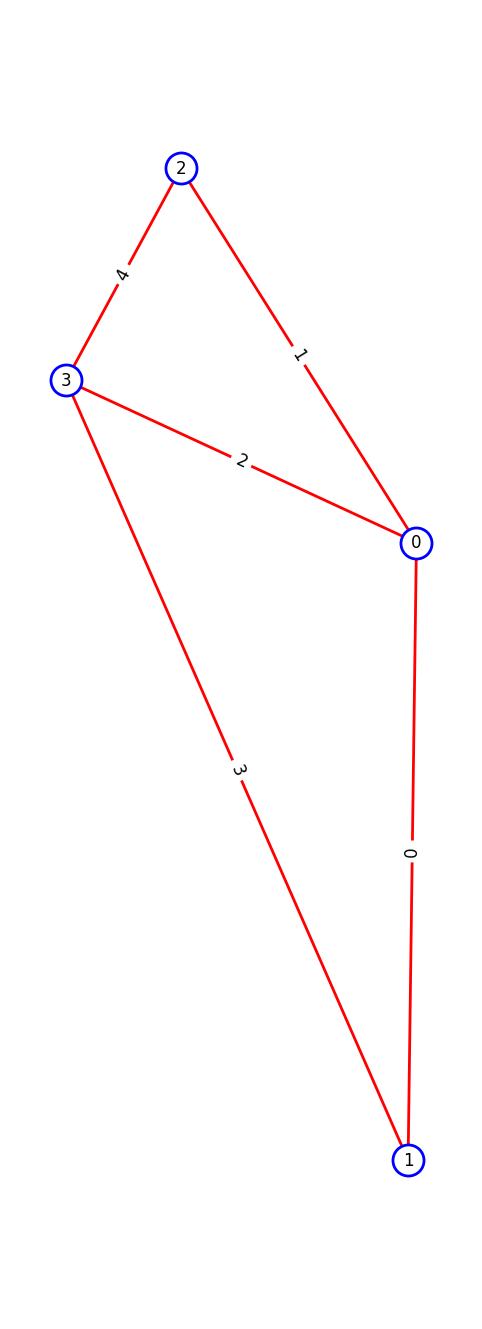

In [23]:
np.random.seed(0)
dn = op.network.Delaunay(points=4, shape=[1, 1, 0])
op.visualization.plot_tutorial(dn);

The basic premise of how OpenPNM stores topology can be stated in 1 sentence:

**The pores on either end of a throat are just another property to be stored, along with diameter, length, etc.**

In other words, referring to the above diagram, throat No. 5 has pores 1 and 4 on its ends.  Using the spreadsheet analogy, this implies a new column that stores the pair of pores connected by each throat.  OpenPNM calls this property ``'throat.conns'``: 

In [24]:
print(dn['throat.conns'])

[[0 1]
 [0 2]
 [0 3]
 [1 3]
 [2 3]]


Inspection of this *Nt-by-2* array shows that each row contains the pore indices corresponding to that throat.

```{note} 
  **Topology Rules**: OpenPNM requires that the following be true about the network:
  1. A throat is a connection between exactly two pores, no more and no less
  2. Throats are non-directional, meaning that flow in either direction is equal
  Other general, but non-essential rules are:
  3. Pores can have an arbitrary number of throats, including zero; however, pores with zero throats lead to singular matrices and other problems so should be avoided.
  4. Two pores are generally connected by no more than one throat. It is technically possible in OpenPNM to have multiple throats between a pair of pores, but it is not rigorously  supported so unintended results may arise. For instance, when converting to CSR format the dual throats are merged into one, so re-converting back results in loss of such throats.
```

### Adjacency Matrices: Dense vs Sparse

The topology storage scheme described above is actually an [adjacency matrix](http://en.wikipedia.org/wiki/Adjacency_matrix), in a [sparse storage format](http://en.wikipedia.org/wiki/Sparse_matrix) known as IJV or COO.  

An adjacency matrix is a *Np*-by-*Np* matrix with non-zero values at location (*i*, *j*) indicating that pores *i* and *j* are connected.  

OpenPNM Network objects have a method that generates the sparse adjacency matrix:

In [25]:
am = dn.create_adjacency_matrix(weights=dn.Ts, triu=True)
print(am)

<COOrdinate sparse matrix of dtype 'int64'
	with 5 stored elements and shape (4, 4)>
  Coords	Values
  (0, 1)	0
  (0, 2)	1
  (0, 3)	2
  (1, 3)	3
  (2, 3)	4


This can be converted to a *dense* array and visualized:

In [26]:
am = dn.create_adjacency_matrix()
print(am.todense())

[[0 1 1 1]
 [1 0 0 1]
 [1 0 0 1]
 [1 1 1 0]]


In dense format the *Np-by-Np* shape is evident. The above matrix is symmetrical, so connections between pore *i* and *j* as well as between *j* and *i* are shown.

An important feature of the adjacency matrix is that it is highly sparse (mostly zeros) and can be stored with a variety of [sparse storage schemes](https://docs.scipy.org/doc/scipy/reference/sparse.html) offered by Scipy.  OpenPNM stores the adjacency matrix in the 'COO' format, which essentially stores the coordinates (I,J) of the nonzero elements in an two-column wide array.

Thus the throat property called ``'throat.conns'`` is an *Nt*-by-2 array that gives the index of the two pores on either end of a given throat.  

```{note} 

  **Additional Thoughts on Sparse Storage:**
  * In pore networks there is (usually) no difference between traversing from pore *i* to pore *j* or from pore *j* to pore *i*, so a 1 is also found at location (*j*, *i*) and the matrix is symmetrical.
  * Since the adjacency matrix is symmetric, it is redundant to store the entire matrix when only the upper triangular part is necessary.  The ``'throat.conns'`` array only stores the upper triangular information, and *i* is always less than *j*.
  * Although this storage scheme is widely known as *IJV*, the ``scipy.sparse`` module calls this the Coordinate or *COO* storage scheme.
  * Some tasks are best performed on other types of storages scheme, such as *CSR* or *LIL*.  OpenPNM converts between these internally as necessary, but users can generate a desired format using the ``create_adjacency_matrix`` method which accepts the storage type as an argument (i.e. ``'csr'``, ``'lil'``, etc).  For a discussion of sparse storage schemes and the respective merits, see this [Wikipedia article](http://en.wikipedia.org/wiki/Sparse_matrix).
```

## ``conduit`` data

A *conduit* in OpenPNM refers to a 'pore-throat-pore' connection, where the pores and throats are each called *elements*. These *elements* act as resistors (or conductors) in series. Each *conduit* therefor contains exactly 1 throat and 2 pores. Transport within the network occurs via these interconnected *conduits*, so the geometric properties of these elements are often needed for computing things like diffusive conductance. This is common enough that OpenPNM V3 includes a new helper function for obtaining this data, as illustrated below:

In [27]:
D = pn.get_conduit_data('diameter')
print(D)

[[0.47440675 0.23720338 0.55759468]
 [0.55759468 0.25069084 0.50138169]
 [0.50138169 0.2362208  0.47244159]]


The above array contains 3 columns, with the center column representing the throat diameter:

In [28]:
print(pn['throat.diameter'])

[0.23720338 0.25069084 0.2362208 ]


And the left and right columns represent the diameter of the pores on each end of the throat. The order of "left" vs "right" reflects the pore indices for the ``'throat.conns'`` array.  

In [29]:
print(pn.conns)

[[0 1]
 [1 2]
 [2 3]]


In fact, the values for the pore elements can be obtained using numpy's fancy indexing:

In [30]:
R1_R2 = pn['pore.diameter'][pn.conns]
print(R1_R2)

[[0.47440675 0.55759468]
 [0.55759468 0.50138169]
 [0.50138169 0.47244159]]


Which can be seen to match the diameter values in ``D`` above. 